# Training Notebook
##1. Flower dataset transfer learning CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image
file_path = 'drive/MyDrive/Project3/'

In [ ]:
data_train = np.load(f'{file_path}data_train.npy').T/255.0
labels_train = np.load(f'{file_path}labels_train.npy').astype(int)
data_train.shape, labels_train.shape

((1658, 270000), (1658,), (415, 270000), (415,))

In [ ]:
X_train, X_val, t_train, t_val = train_test_split(data_train, labels_train, test_size=0.1, random_state=42)
X_train.shape, X_val.shape, t_train.shape, t_val.shape

((1492, 270000), (166, 270000), (1492,), (166,))

In [ ]:
X_dim, Y_dim = 300,300

X_train = tf.constant(X_train.reshape((X_train.shape[0],X_dim,Y_dim,3)), 
                         dtype=tf.float32)
  
X_train.shape

TensorShape([1492, 300, 300, 3])

In [ ]:
X_val = tf.constant(X_val.reshape((X_val.shape[0],X_dim,Y_dim,3)), 
                         dtype=tf.float32)
  
X_val.shape

TensorShape([166, 300, 300, 3])

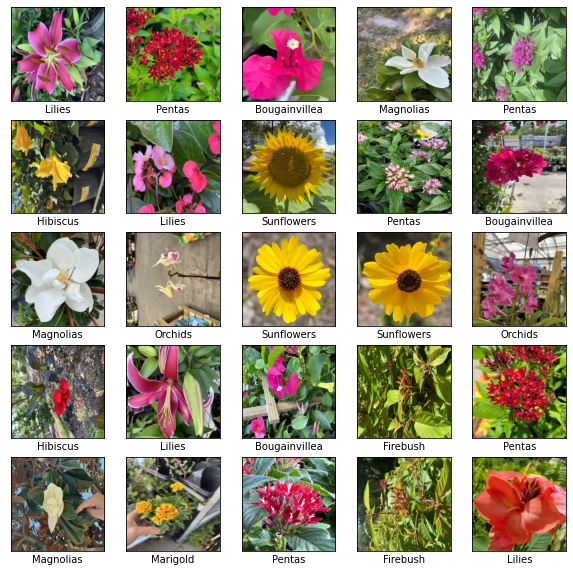

In [ ]:
class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 'Marigold', 
               'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(data_train[i].reshape(300,300,3))
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[int(labels_train[i])])
plt.show()

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
IMG_SIZE = 150

inputs = keras.Input(shape=(300, 300, 3))
# Input layer

inputs_resized = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) # 150-150-3
# resizing input to match pretrained model

x = base_model(inputs_resized, training=False)

In [ ]:
inputs.shape, inputs_resized.shape, x.shape

(TensorShape([None, 300, 300, 3]),
 TensorShape([None, 150, 150, 3]),
 TensorShape([None, 5, 5, 2048]))

In [ ]:
x_pooling = keras.layers.GlobalAveragePooling2D()(x)

x_pooling.shape

TensorShape([None, 2048])

In [ ]:
outputs = keras.layers.Dense(10, activation='softmax')(x_pooling)

# Assembling model
model = keras.Model(inputs, outputs)

In [ ]:
inputs.shape, inputs_resized.shape, x.shape, outputs.shape

(TensorShape([None, 300, 300, 3]),
 TensorShape([None, 150, 150, 3]),
 TensorShape([None, 5, 5, 2048]),
 TensorShape([None, 10]))

In [ ]:
with tf.device('/device:GPU:0'):
  model.compile(optimizer=keras.optimizers.Nadam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(X_train,t_train, epochs=100, batch_size=32,
              validation_data=(X_val, t_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=30)])

Epoch 1/100
47/47 [==============================] - 7s 98ms/step - loss: 0.4015 - accuracy: 0.8981 - val_loss: 0.5387 - val_accuracy: 0.8494
Epoch 2/100
47/47 [==============================] - 4s 77ms/step - loss: 0.3354 - accuracy: 0.9243 - val_loss: 0.5240 - val_accuracy: 0.8434
Epoch 3/100
47/47 [==============================] - 4s 77ms/step - loss: 0.2895 - accuracy: 0.9417 - val_loss: 0.4874 - val_accuracy: 0.8434
Epoch 4/100
47/47 [==============================] - 4s 78ms/step - loss: 0.2553 - accuracy: 0.9477 - val_loss: 0.5022 - val_accuracy: 0.8675
Epoch 5/100
47/47 [==============================] - 4s 78ms/step - loss: 0.2276 - accuracy: 0.9551 - val_loss: 0.4825 - val_accuracy: 0.8554
Epoch 6/100
47/47 [==============================] - 4s 78ms/step - loss: 0.2024 - accuracy: 0.9638 - val_loss: 0.4696 - val_accuracy: 0.8614
Epoch 7/100
47/47 [==============================] - 4s 84ms/step - loss: 0.1845 - accuracy: 0.9718 - val_loss: 0.4636 - val_accuracy: 0.8614
Epoch 

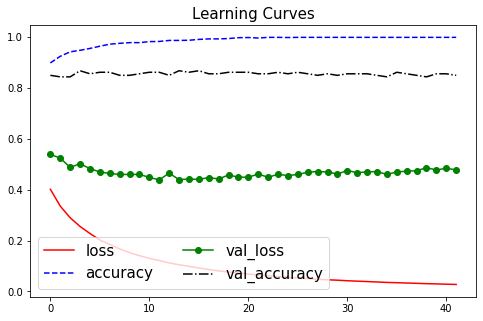

In [ ]:
key_names = list(history.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(8,5))
for i in range(len(key_names)): # starting from 1 otherwise you cant see anything due to extremely high loss at start
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);

In [ ]:
y_train = np.argmax(model.predict(X_train),axis=1)

y_train.shape

47/47 [==============================] - 4s 65ms/step


(1492,)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(t_train, y_train, target_names=class_names))

               precision    recall  f1-score   support

        Roses       0.80      0.88      0.84       160
    Magnolias       0.97      0.94      0.96       163
       Lilies       0.90      0.81      0.85       185
   Sunflowers       0.99      0.91      0.95       125
      Orchids       0.94      0.91      0.92       150
     Marigold       0.94      0.96      0.95       140
     Hibiscus       0.88      0.88      0.88       145
     Firebush       0.83      0.96      0.89       152
       Pentas       0.92      0.96      0.94       146
Bougainvillea       0.92      0.87      0.89       126

     accuracy                           0.91      1492
    macro avg       0.91      0.91      0.91      1492
 weighted avg       0.91      0.91      0.91      1492



In [ ]:
model.save(f'{file_path}flower_model.h5')

##2. Validation metric

In order to validate the performance in the test set I will measure the amount of shared area between the proper bounding box and the predicted one from the model. Then taking the union of the two boxes and subtracting the overlap to get a score. This results a score of 1 if both bounding boxes are the same, otherwise the score decreases as the amount of overlap decreases.

The training data will be updated to set [0,0,0,0] for all pictures without cars.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import pandas as pd
import os
import gc

In [2]:
bbox = pd.read_csv(f'car_detection_dataset/train_bounding_boxes.csv')

In [4]:
print(len(bbox))

559


In [6]:
print(len(os.listdir(f'training images/')))

1001


In [3]:
# Create a numpy array with all images
i=0
zero_count = 0
for filename in os.listdir(f'training images/'): 
    image = np.array(Image.open(f'training images/'+filename))
    image_col = image.ravel()[:,np.newaxis]
    labels = bbox[bbox['image']==filename].drop('image', axis=1).round().to_numpy().astype(int)
    if len(labels)>0:
      for label in labels:
        if i==0:
            X_train = image_col
            t_train = label
            i=1
        else:
            X_train = np.hstack((X_train, image_col))
            t_train = np.vstack((t_train, label))
    elif zero_count<100:
      zero_count +=1  
      if i==0:
            X_train = image_col
            t_train = [0,0,0,0]
            i=1
      else:
          X_train = np.hstack((X_train, image_col))
          t_train = np.vstack((t_train, [0,0,0,0]))
    
    

# Training feature matrices
X_train = X_train.T/255

X_train.shape, t_train.shape

((659, 770640), (659, 4))

In [5]:
# size of each RGB image
(Nx,Ny,Nz) = (380, 676, 3) # image.shape

Nx, Ny, Nz

(380, 676, 3)

In [5]:
np.save(f'car_data_train.npy', X_train)
np.save(f'car_labels_train.npy', t_train)

In [2]:
X_train = np.load(f'car_data_train.npy')
t_train = np.load(f'car_labels_train.npy')

In [3]:
X_train = X_train[:int(len(X_train)*.8)]
t_train = t_train[:int(len(t_train)*.8)]
X_val = X_train[int(len(X_train)*.8):]
t_val =  t_train[int(len(t_train)*.8):]
X_train.shape, X_val.shape, t_train.shape, t_val.shape

((527, 770640), (106, 770640), (527, 4), (106, 4))

In [6]:
# X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size=0.1, random_state=42)
# X_train.shape, X_val.shape, t_train.shape, t_val.shape
# crashing ram

((593, 770640), (66, 770640), (593, 4), (66, 4))

In [6]:
X_dim, Y_dim = Nx, Ny

if X_dim < Nx:
    for i in range(len(t_train)):
        t_train[i] = [t_train[i][0]/(X_dim/Nx),t_train[i][1]/(Y_dim/Ny),t_train[i][2]/(X_dim/Nx),t_train[i][3]/(Y_dim/Ny)]
    for i in range(len(t_val)):
        t_val[i] = [t_val[i][0]/(X_dim/Nx),t_val[i][1]/(Y_dim/Ny),t_val[i][2]/(X_dim/Nx),t_val[i][3]/(Y_dim/Ny)]

X_train_tensor = X_train.reshape((X_train.shape[0],Nx,Ny,3))
  
X_train_tensor.shape

(527, 380, 676, 3)

In [7]:
X_val_tensor = X_val.reshape((X_val.shape[0],Nx,Ny,3))
  
X_val_tensor.shape

(106, 380, 676, 3)

In [8]:
del X_train
del X_val

In [9]:
gc.collect()

466

In [23]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(X_dim, Y_dim, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83697664/83683744 [==============================] - 4s 0us/step


In [24]:
base_model.trainable = False

In [25]:
inputs = keras.Input(shape=(380, 676, 3))
# Input layer

# inputs_resized = keras.layers.Resizing(X_dim, Y_dim)(inputs) # 150-150-3
# resizing input to match pretrained model

# x = base_model(inputs_resized, training=False)
x = base_model(inputs, training=False)

In [26]:
inputs.shape, x.shape #, inputs_resized.shape, x.shape

(TensorShape([None, 380, 676, 3]), TensorShape([None, 12, 21, 2048]))

In [27]:
x_pooling = keras.layers.GlobalAveragePooling2D()(x)

x_pooling.shape

TensorShape([None, 2048])

In [28]:
outputs = keras.layers.Dense(128, activation='relu')(x_pooling)
outputs = keras.layers.Dense(64, activation='relu')(outputs)
outputs = keras.layers.Dense(32, activation='relu')(outputs)
outputs = keras.layers.Dense(4, activation='relu')(outputs)

# Assembling model
model = keras.Model(inputs, outputs)

In [29]:
# with tf.device('/device:GPU:0'):
model.compile(optimizer=keras.optimizers.Nadam(),
            loss=keras.losses.MeanSquaredError(),
            metrics=['accuracy'])

history = model.fit(X_train_tensor,t_train, epochs=100, batch_size=4,
          validation_data=(X_val_tensor, t_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=30)])

Epoch 1/100
132/132 [==============================] - 6s 33ms/step - loss: 48264.3906 - accuracy: 0.4137 - val_loss: 45818.6875 - val_accuracy: 0.6792
Epoch 2/100
132/132 [==============================] - 3s 21ms/step - loss: 37496.7070 - accuracy: 0.5503 - val_loss: 45835.7305 - val_accuracy: 0.6792
Epoch 3/100
132/132 [==============================] - 3s 21ms/step - loss: 35426.3750 - accuracy: 0.5503 - val_loss: 44835.9297 - val_accuracy: 0.6792
Epoch 4/100
132/132 [==============================] - 3s 21ms/step - loss: 34683.9180 - accuracy: 0.5522 - val_loss: 45260.7266 - val_accuracy: 0.6792
Epoch 5/100
132/132 [==============================] - 3s 21ms/step - loss: 34217.0156 - accuracy: 0.5522 - val_loss: 45176.1133 - val_accuracy: 0.6792
Epoch 6/100
132/132 [==============================] - 3s 21ms/step - loss: 33587.0586 - accuracy: 0.5579 - val_loss: 44486.3555 - val_accuracy: 0.6887
Epoch 7/100
132/132 [==============================] - 3s 21ms/step - loss: 32982.4414 -

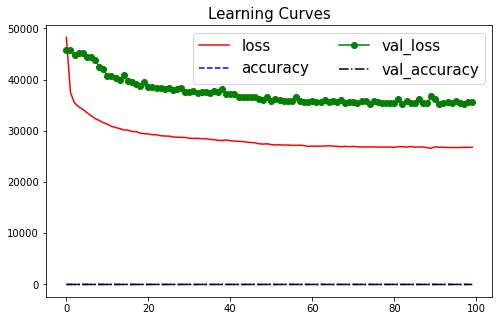

In [30]:
key_names = list(history.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(8,5))
for i in range(len(key_names)): # starting from 1 otherwise you cant see anything due to extremely high loss at start
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);

In [31]:
y_train = model.predict(X_train_tensor)

y_train.shape

(527, 4)

In [32]:
from sklearn.metrics import r2_score

r2_score(t_train, y_train)

0.4040492300262538

In [33]:
y_val = model.predict(X_val_tensor)

y_train.shape

(527, 4)

In [34]:
r2_score(t_val, y_val)

-0.4136733393259445

In [35]:
print(t_train[0], y_train[0])

[0 0 0 0] [0. 0. 0. 0.]


In [36]:
model.save('car_model.h5')

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
